# Graph neural networks in PyTorch

Graph neural networks have emerged as a powerful approach to bring machine learning to systems that can be described by graphs, i.e. by nodes that are connected by edges. This can be, for example, a social graph (such as your connections on social media), or, in natural sciences and engineering, a modecule or a crystal. For molecules and crystals, the nodes are represented by atoms (or maybe atom groups) and the edges, i.e. the connections between the nodes (atoms) are the bonds between the atoms. In the end, the macroscopic properties of a molecule or crystal emerge from the complex interplay between the atoms and their bonds. Using graph neural networks, we want to model this. Instead of building a range of feature variables that describe, for example, the position of the atoms and their immediate or far-ranged envioronment, we start by representing the molecule or crystal as a graph and assign node properties (i.e. features of the atom such as, for example, its position in the periodic table, mass, etc.) and edge features (e.g. specific bonds that are formed).

In this exercise, we focus on the [QM9 dataset](https://www.nature.com/articles/sdata201422) with a more detailed [description of QM9](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/qm9.html), as a publicly availble dataset that is already being brought to a form where we can use it for training a graph neural network.
The data contain details about 130,000 molecules and there are 19 regression targets for which we can train a GNN.

Here, we focus on building the GNN - but a major part of the work would be to create a dataset to use with this network.
The implementation of the GNN will follow the footsteps of  graph convolutions described in the paper [Neural Message Passing for Quantum Chemistry](https://arxiv.org/abs/1704.01212) by Gilmer et al. (2017). These are implemented as [NNConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.NNConv) in the toolkit [PyG](https://pytorch-geometric.readthedocs.io/en/latest/) (PyTorch Geometric) that provides a wide range of functions to build graph neural networks.

The task of this exercise is to predict the isotropic polarizability (the molecule's response of its charge in an external electric field). This is a regression task. For simplicity, we will predict this quantity as a single real-valued number.


The main code of this exerercise was taken from the book [Machine Learning with PyTorch and Scikit-Learn](https://sebastianraschka.com/books/)

In [ ]:
# Only on Colab, etc
# see https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
# only works for pip at the moment
# !pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu117.html

In [1]:
import torch

from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
from torch_geometric.utils import to_networkx

# visualising graphs
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import numpy as np

/home/kerzel/.cache/pypoetry/virtualenvs/datascienceintro-eVBNPtpL-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Access

As mentioned above, we will use the [QM9 dataset](https://www.nature.com/articles/sdata201422) in this example. PyTorch-Geometric provides us with a convenient wrapper to access the data.

In [2]:
data_set = QM9('data/qm9')
print('number of data points: ', len(data_set))


Extracting data/qm9/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


number of data points:  130831


## Data Exploration

The base format of the library PyTorch Geometric is the [Data](torch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data) object that describes the graph.

In other machinee learning tasks, the data were given, for example, by a table consisting of feature variables and the target/label (for structured data), or an image together with a label for image analysis tasks.

Now that we consider graphs, we need to store information about the nodes, the edges (and connection between nodes),as well as the target information.

The part ```data.x``` describes the note feature matrix describing, for example, the atoms. The dimensions of this matrix is ```[num_nodes, num_node_features]```

The target (label) is given by ```data.y```. In graphs, we can now have multiple layers of targets. We can, for example, have targets that describe the whole graph. In our case, this is the isotropic polarizability. In this case, the shape of the target array is ```[1,*]```, where the ```*``` indicates that we can have many targets to train on (19 in this dataset), that are conveniently combined into the same object.
In other situation, we would predict properties of the nodes, in this case the shape of the target object is ```[num_nodes, *]```

We also need to describe the edges connecting the nodes and we use the ```data.edge_index``` (in [COO](https://pytorch.org/docs/stable/sparse.html#sparse-coo-docs) format) to describe which node (atom) is connected to which. The shape of this matrix is ```[2, num_edges]```. We also need to describe the attribute of each edge which is done using ```data.edge_attr``` of shape ```[num_edges, num_edge_features]```.

The ```data``` object also allows us to store new variables in this object, depending on our needs for the specific task at hand.

In [3]:
# first element in the list of all the graphs describing molecules
graph_0 = data_set[0]
print('Data type {}'.format(type(graph_0)))

print('number of nodes (atoms): {}'.format(graph_0.num_nodes))
print('number of edges (bonds): {}'.format(graph_0.num_edges))

print('number of node features: {}'.format(graph_0.num_node_features))
print('number of edge features: {}'.format(graph_0.num_edge_features))

print('------------------- \n')

print('node features: {}'.format(graph_0.x))

print('------------------- \n')

print('target shape: {}'.format(graph_0.y.shape))

print('------------------- \n')
print('edge features: {}'.format(graph_0.edge_attr))

# loop over everything in the data object
print('------------------- \n')
print('------------------- \n')
for key, item in graph_0:
  print(f'{key} : {item}')

Data type <class 'torch_geometric.data.data.Data'>
number of nodes (atoms): 5
number of edges (bonds): 8
number of node features: 11
number of edge features: 4
------------------- 

node features: tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
------------------- 

target shape: torch.Size([1, 19])
------------------- 

edge features: tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])
------------------- 

------------------- 

x : tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0.,

Much of the actual work then consists of putting these data for node and edge features together. The details are described in the [QM9](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/qm9.html) documentation, in particular, the ```proceess()``` function.

For example, the edge attributes are one-hot encoded descriptions of the bond type ```bonds = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3}```, 
the ```x``` part for the node attributes includes information about the atomic number, the hybridisation of atomic orbitals, etc.


Using the [NetworkX](https://networkx.org/) package, we can visualise the graph that belongs to this molecule.

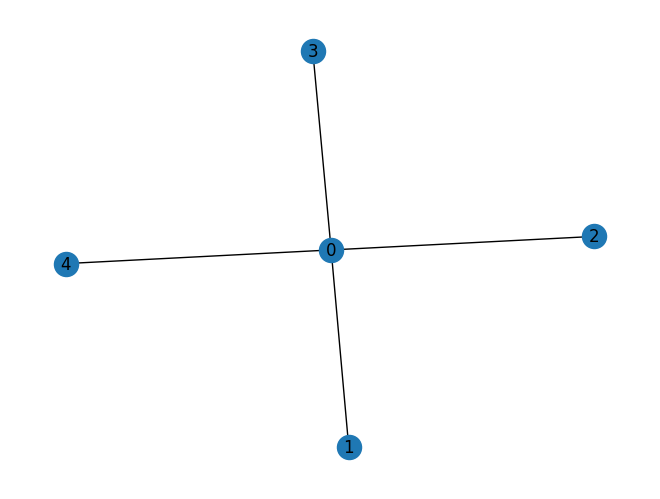

In [4]:
G = to_networkx(graph_0, to_undirected=True)
nx.draw_spring(G, with_labels = True) 


# Graph Neural Network setup

Now we define a Graph Neural Network (GNN).
The overall task we aim to achieve is graph regression: we want to predict a continuous quanity described by the whole graph.

We will use graph convolutional layers - remember that each layer added corresponds to a "hop" from which we can receive information. Hence, adding N layers means we can reach nodes up to N "hops" away.

In particular, we use the class [``NNConv``](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.NNConv) from ``PyTorch Geometric`` that implements the approach described in [Neural Message Passing for Quantum Chemistry](https://arxiv.org/abs/1704.01212). Here, a (small) neural network (the "Edge Network") in the paper maps the edge vector to a matrix that is then used in the convolution - essentially, our learnable filter. This network can, e.g. be specified by ``torch.nn.Sequential``.


From the documentation of ``NNconv``: A neural network that maps edge features edge_attr of shape [-1, num_edge_features] to shape [-1, in_channels * out_channels]

The [``global_add_pool``](https://pytorch-geometric.readthedocs.io/en/latest/modules/graphgym.html?highlight=global_add_pool#torch_geometric.graphgym.models.global_add_pool) adds the node features.

Note that for simplicity we only predict a single number.

In order to exploit the edge features, we use two small fully connected networks. Since we do not require much flexibility, we use the [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) method to define the network and its layers. This is not as powerful as writting our custom classes, however, it is more convenient for small networks - and also, the class [NNConv](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/nn_conv.html) requires us to use this format. 
These edge networks get passed as a parameter to the graph convolutional layer.

In the later setup of our own network ```class ConvNet``` we then revert back to the more powerful way of defining a network.

In a more compact way of writing, our network consists of:
-  2 graph convolutional layers, 
- that are passed through the ```ReLU``` activation function, 
- global pooling
- a fully connected layer that that takes the output of the graph convolution (i.e. the features our network has built itself)
- a fully connected layer as "regression head", i.e. with 1 output node that describes the value of the target we want to predict.

In [6]:
class ConvNet(nn.Module):
  def __init__(self, num_node_features, num_edge_features):
    
    # initialize the base class (Module from torch.nn)
    super().__init__()


    # define small networks for the edge features.
    edge_net_1 = nn.Sequential(
        nn.Linear(num_edge_features, 32),
        nn.ReLU(),
        nn.Linear(32, num_node_features*32)
    )

    edge_net_2 = nn.Sequential(
        nn.Linear(num_edge_features, 32),
        nn.ReLU(),
        nn.Linear(32, 32*16)
    )

    # now we define the layers we want to use in our GNN

    # we use two graph convolutional layers: 
    # NNConv(#input channels, #output channels, edge_net)
    self.conv_1 = NNConv(num_node_features, 32, edge_net_1)
    self.conv_2 = NNConv(32, 16, edge_net_2)
    
    # then a dense (fully-connected) layer for the regression 
    # of the output of the graph convolution
    self.fc_1 = nn.Linear(16, 32)

    # and a linear layer to map the output to the single number 
    # we want to predict
    self.out = nn.Linear(32,1)

  # define the forward pass, i.e. how the various network components
  # interact and how we build the final model.
  def forward(self, data):
    
    #unpack the data
    batch, x, edge_index, edge_attr = (
        data.batch, data.x, data.edge_index, data.edge_attr
    )

    #now build the network
    # start with the graph convolutional layers
    x = F.relu(self.conv_1(x, edge_index, edge_attr))
    x = F.relu(self.conv_2(x, edge_index, edge_attr))
    # add node features
    x = global_add_pool(x, batch)
    # regression head
    x = F.relu(self.fc_1(x))
    # final output
    output = self.out(x)
    return output


We split the data into trainnig and testing sample.
PyTorch provides a similar functionality to Scikit-Learn to split a given dataset into a test/train/validation sample with [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)

In [7]:
# create training, test and validation samples
# the length of the overall dataset is: 130831, so we use
# the bulk for training and around 10% for validation and testing
# (put the 831 samples to the validation test, avoid somewhat awkward split
#  to make the numbers the same...)
train_set, validation_set, test_set = torch.utils.data.random_split(
    data_set, [110000, 10831, 10000]
)

train_loader      = DataLoader(train_set, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)
test_loader       = DataLoader(test_set, batch_size=32, shuffle=True)


## Network Training

Now we set the network up as we did in other cases. Once we have defined the graph neural network using PyTorch Geometric, the interface is identical to the standard PyTorch interface.

We create an instance of our network, define an optimizer (and, if we want, a learning rate scheduler), and move the model (and the data) to the training device (i.e. GPU or CPU)

In [8]:
# setup a network
net = ConvNet(data_set.num_node_features,
              data_set.num_edge_features)

# optimizier for the training
optimizer = torch.optim.Adam(
    net.parameters(), lr=0.01
)

# training epochs
epochs = 4

# predict the polarizability (index 1 in the dataset)
target_idx = 1

# training device: CPU/GPU
device = torch.device('cuda:0' if 
                       torch.cuda.is_available() else 'cpu')
print('Train on: ', device)

net.to(device)


Train on:  cpu


ConvNet(
  (conv_1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv_2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

The training loop is similar to what we have encountered before.

As we now have a regression task, we need to choose an appropriate loss function. The most commonly used type is the mean squared error (MSE) which is provided by [mse_loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss).

Because of the way we access the data, we need to "move things around a bit" to bring it into the correct shape for comparison. Note that there is more than one way to obtain the data from the dataloader: Here, we access the batch of data itself, so we need to 
- access the target value ```y```
- since there are 19 possible targets for this dataset, we need to access the right one via ```target_idx```.
- bring it into the correct shape so that we can compare the values output <-> prediction which is done by [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html). Since we chain the operations here with multiple ```.```, we provide the desired dimension as parameter to unsqueze.

In [9]:
# training loop
for epoch in range(epochs):
  epoch_loss = 0


  #set the network into training mode
  net.train()
  for batch in train_loader:
    batch.to(device)
    optimizer.zero_grad()
    output = net(batch)
    loss = F.mse_loss(
        output, batch.y[:, target_idx].unsqueeze(1)
    )
    loss.backward()
    epoch_loss += loss.item()
    optimizer.step()

  train_avg_loss = epoch_loss/len(train_loader.dataset)


  val_loss = 0
  #set the network in evaluation mode
  net.eval()
  for batch in validation_loader:
    batch.to(device)
    output = net(batch)
    loss = F.mse_loss(
        output, batch.y[:, target_idx].unsqueeze(1)
    )
    val_loss += loss.item()

  val_avg_loss = val_loss/len(validation_loader.dataset)


  print(f'Epoch # {epoch}, avg. train_loss {train_avg_loss:.2f}, avg. validation loss {val_avg_loss:.2f}')

Epoch # 0, avg. train_loss 0.86, avg. validation loss 0.27
Epoch # 1, avg. train_loss 0.18, avg. validation loss 0.11
Epoch # 2, avg. train_loss 0.12, avg. validation loss 0.10
Epoch # 3, avg. train_loss 0.11, avg. validation loss 0.09


# Evaluation

Finally, we use the trained network to predict the desired target quantity.
We need to remember to put the odel into ```eval()``` mode and move data, as well as the model to the GPU (if we have one).

Then we loop over the test data and store the predictions together with the true value. Ideally, we would expect a straight line and each prediction is very close to the true value

In [10]:
net.eval()
predictions = []
truth = []

# detach the ouput (predictions) from the computational graph of the model
# move it to the CPU so we can use it and convert it to numpy format
# so we can work with it later (e.g. plot)
for batch in test_loader:
  batch.to(device)
  output = net(batch)
  predictions.append(output.detach().cpu().numpy())
  truth.append(batch.y[:, target_idx].detach().cpu().numpy())

truth = np.concatenate(truth)
predictions = np.concatenate(predictions)

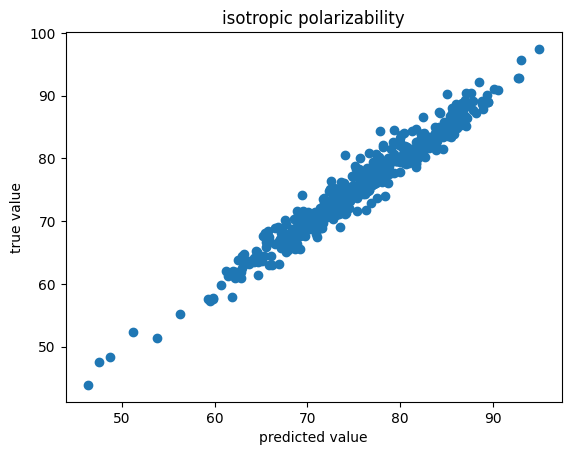

In [11]:
plt.scatter(predictions[:500],truth[:500])
plt.ylabel('true value')
plt.xlabel('predicted value')
plt.title('isotropic polarizability')
plt.show()